In [1]:
from tools import load_config
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor




# Load the config.yaml
config = load_config("config.yaml")

# Extract the processed data location
processed_data_location = config["processed_data_location"]

# Load the processed data into a DataFrame
import pandas as pd
data = pd.read_csv(processed_data_location)

# Display the DataFrame
data.head()


c:\Users\Danylo\Desktop\MainCategories\MastersDiploma\Practice\program\src\config.yaml


,subjid,sex,vomitfl,temp,virusfl,hosp_days,age_years,antibioticfl,analgesicfl,probioticfl,treatment_combination,combination_description,dehsev_Mild dehydration,dehsev_No dehydration,dehsev_Severe dehydration,BMI,vomit_avgfrq
0,1,2,1,37.8,1,3,0.393607,0,0,0,0,No treatments,False,False,True,13.611111,2.5
1,2,1,1,39.0,1,3,1.893607,0,0,0,0,No treatments,True,False,False,13.442554,3.5
2,3,1,0,37.1,1,5,1.868950,0,0,0,0,No treatments,True,False,False,19.333730,NaN
3,4,2,1,37.7,1,2,0.657306,0,1,0,1,Analgesic only,False,False,True,16.568047,2.5
4,7,1,1,36.5,1,1,0.885388,0,0,0,0,No treatments,False,False,True,11.108907,1.5


In [2]:
data.columns = data.columns.str.strip().str.replace(" ", "_")

In [3]:
data.columns 

Index(['subjid', 'sex', 'vomitfl', 'temp', 'virusfl', 'hosp_days', 'age_years',
       'antibioticfl', 'analgesicfl', 'probioticfl', 'treatment_combination',
       'combination_description', 'dehsev_Mild_dehydration',
       'dehsev_No_dehydration', 'dehsev_Severe_dehydration', 'BMI',
       'vomit_avgfrq'],
      dtype='object')

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.impute import SimpleImputer


# Prepare the data
unique_treatment_combinations = data['treatment_combination'].unique()
covariates = [
    'age_years', 'sex', 'BMI', 'temp', 
    'vomitfl', 'virusfl', 
    'dehsev_Mild_dehydration', 
    'dehsev_Severe_dehydration',
    'dehsev_No_dehydration',
     'vomit_avgfrq'
]

imputer = SimpleImputer(strategy='mean')  # Replace 'mean' with 'median' or other strategies if needed
data[covariates] = imputer.fit_transform(data[covariates])



scaler = StandardScaler()
X = scaler.fit_transform(data[covariates])

def psm(data, X, treatment_combinations):
    """
    Perform Propensity Score Matching (PSM) for multiple treatment groups.
    
    Parameters:
        data (pd.DataFrame): The dataset containing the treatment and covariate data.
        X (np.ndarray): Scaled covariates used to estimate propensity scores.
        treatment_combinations (list): List of unique treatment combinations.
        
    Returns:
        dict: Dictionary where each treatment group is mapped to its matched pairs dataframe.
    """
    binary_psm_results = {}
    
    for treatment_group in treatment_combinations:
        # Create binary treatment variable
        data['binary_treatment'] = (data['treatment_combination'] == treatment_group).astype(int)
        
        # Estimate propensity scores for the binary treatment
        logreg = LogisticRegression(max_iter=1000)
        logreg.fit(X, data['binary_treatment'])
        data['propensity_score'] = logreg.predict_proba(X)[:, 1]
        
        # Perform nearest-neighbor matching
        treated_idx = data[data['binary_treatment'] == 1].index
        control_idx = data[data['binary_treatment'] == 0].index
        
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(data.loc[control_idx, 'propensity_score'].values.reshape(-1, 1))
        distances, neighbors = nn.kneighbors(
            data.loc[treated_idx, 'propensity_score'].values.reshape(-1, 1)
        )
        
        # Store matched pairs
        matched_pairs = pd.DataFrame({
            'treated': treated_idx,
            'matched': control_idx[neighbors.flatten()],
            'distance': distances.flatten()
        })
        
        binary_psm_results[treatment_group] = matched_pairs
    
    return binary_psm_results

def evaluate_balance(matched_pairs, data, covariates):
    """
    Evaluate covariate balance for matched pairs.
    
    Parameters:
        matched_pairs (pd.DataFrame): DataFrame containing treated and matched indices.
        data (pd.DataFrame): The original dataset containing covariates.
        covariates (list): List of covariate column names.
        
    Returns:
        pd.DataFrame: DataFrame with covariates and their standardized differences.
    """
    balance = []
    for cov in covariates:
        treated_vals = data.loc[matched_pairs['treated'], cov].values
        matched_vals = data.loc[matched_pairs['matched'], cov].values
        standardized_diff = (treated_vals.mean() - matched_vals.mean()) / data[cov].std()
        balance.append({'Covariate': cov, 'Standardized Difference': standardized_diff})
    return pd.DataFrame(balance)

# Perform PSM
binary_psm_results = psm(data, X, unique_treatment_combinations)

# Evaluate balance for one of the groups
selected_group = unique_treatment_combinations[1]  # Pick any group to analyze
selected_matched_pairs = binary_psm_results[selected_group]

# Calculate covariate balance
balance = evaluate_balance(selected_matched_pairs, data, covariates)


In [5]:
balance

,Covariate,Standardized Difference
0,age_years,0.030923
1,sex,-0.021294
2,BMI,-0.151163
3,temp,0.120811
4,vomitfl,-0.049660
5,virusfl,0.000000
6,dehsev_Mild_dehydration,-0.074882
7,dehsev_Severe_dehydration,0.038306
8,dehsev_No_dehydration,0.059322
9,vomit_avgfrq,0.077568


In [6]:
combination_mapping = {
    '000': 'Без лікування',
    '100': 'Тільки антибіотик',
    '010': 'Тільки пробіотик',
    '001': 'Тільки анальгетик',
    '110': 'Антибіотик і пробіотик',
    '101': 'Антибіотик і анальгетик',
    '011': 'Пробіотик і анальгетик',
    '111': 'Усі три види лікування'
}


In [7]:
combination_mapping['0'] = 'Без лікування'


In [8]:
combination_mapping.update({
    '1': 'Тільки пробіотик',
    '10': 'Тільки анальгетик',
    '11': 'Пробіотик і анальгетик'
})

In [9]:
# Function to calculate and collect balance for all treatment groups
def calculate_all_balances(psm_results, data, covariates):
    """
    Calculate covariate balance for all treatment groups.
    
    Parameters:
        psm_results (dict): Dictionary of matched pairs for each treatment group.
        data (pd.DataFrame): The original dataset containing covariates.
        covariates (list): List of covariate column names.
        
    Returns:
        pd.DataFrame: DataFrame containing covariate balances for all treatment groups.
    """
    all_balances = []
    for group in psm_results:
        matched_pairs = psm_results[group]
        group_balance = evaluate_balance(matched_pairs, data, covariates)
        group_balance['Treatment Group'] = group
        all_balances.append(group_balance)
    return pd.concat(all_balances, ignore_index=True)

# Perform PSM for all treatment groups
binary_psm_results = psm(data, X, unique_treatment_combinations)

# Evaluate balance for a selected treatment group
selected_group = unique_treatment_combinations[1]  # Pick any group to analyze
selected_matched_pairs = binary_psm_results[selected_group]

# Calculate covariate balance for the selected group
balance = evaluate_balance(selected_matched_pairs, data, covariates)

# Calculate balances for all treatment groups
all_balances = calculate_all_balances(binary_psm_results, data, covariates)


In [10]:
all_balances

,Covariate,Standardized Difference,Treatment Group
0,age_years,0.085018,0
1,sex,-0.011263,0
2,BMI,0.097255,0
3,temp,-0.019229,0
4,vomitfl,-0.118199,0
...,...,...,...
75,virusfl,0.000000,110
76,dehsev_Mild_dehydration,0.000000,110
77,dehsev_Severe_dehydration,0.000000,110
78,dehsev_No_dehydration,0.000000,110


In [11]:
# Convert 'Treatment Group' to string before mapping
all_balances['Treatment Group'] = all_balances['Treatment Group'].astype(str)
all_balances['Treatment Group Name'] = all_balances['Treatment Group'].map(combination_mapping)


In [12]:
covariate_mapping = {
    'age_years': 'Вік (роки)',
    'sex': 'Стать',
    'BMI': 'ІМТ (Індекс маси тіла)',
    'temp': 'Температура',
    'vomitfl': 'Блювота',
    'virusfl': 'Вірусна інфекція',
    'dehsev_Mild_dehydration': 'Легке зневоднення',
    'dehsev_Severe_dehydration': 'Важке зневоднення',    
    'dehsev_No_dehydration': 'Немає зневоднення',
    "vomit_avgfrq" : 'Середня частота блювання'
}

# Перейменування коваріатів в даних
all_balances['Covariate'] = all_balances['Covariate'].map(covariate_mapping)


In [13]:
# Identify any treatment groups that were not mapped (if any)
unmapped_groups = data[data['treatment_combination'].isna()]['treatment_combination'].unique()
if len(unmapped_groups) > 0:
    print("\nUnmapped treatment groups found:")
    print(unmapped_groups)
else:
    print("\nAll treatment groups mapped successfully.")


All treatment groups mapped successfully.


In [14]:
# Define the selected treatment groups as integers
selected_groups = [0, 10, 1, 100]  # Corresponding to '000', '010', '001', '100'

# Filter the dataset for the selected treatment groups
filtered_data = data[data['treatment_combination'].isin(selected_groups)].copy()

In [15]:
# Standardize covariates
scaler = StandardScaler()
X_filtered = scaler.fit_transform(filtered_data[covariates])

# Perform Propensity Score Matching for the selected treatment groups
binary_psm_results = psm(filtered_data, X_filtered, selected_groups)

# Calculate covariate balance for all selected groups using the pre-defined function
all_balances_df = calculate_all_balances(binary_psm_results, filtered_data, covariates)

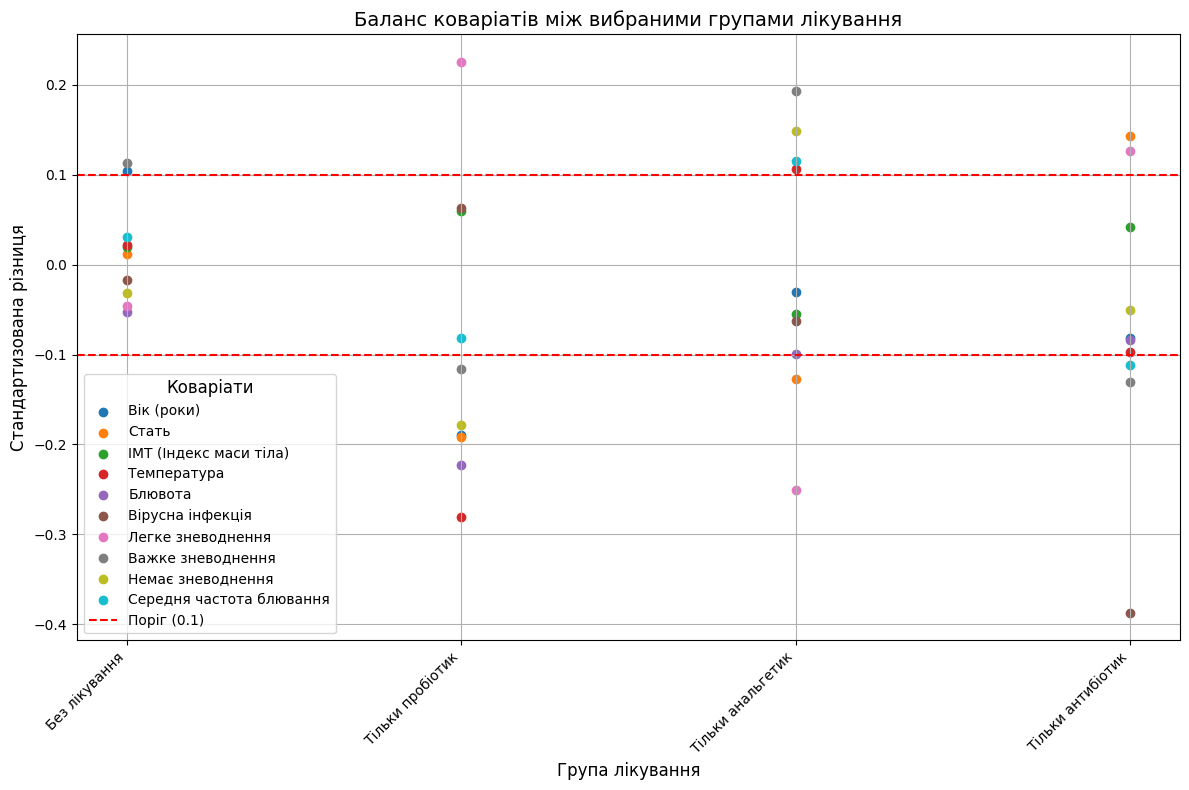

In [16]:
# Створюємо мапінг для груп лікування
group_mapping = {
    0: 'Без лікування',
    10: 'Тільки пробіотик',
    1: 'Тільки анальгетик',
    100: 'Тільки антибіотик'
}

# Додаємо колонку 'Treatment Group Name' до all_balances_df
all_balances_df['Treatment Group Name'] = all_balances_df['Treatment Group'].map(group_mapping)

# Словник для перекладу коваріатів
covariate_mapping_ukrainian = {
    'age_years': 'Вік (роки)',
    'sex': 'Стать',
    'BMI': 'ІМТ (Індекс маси тіла)',
    'temp': 'Температура',
    'vomitfl': 'Блювота',
    'virusfl': 'Вірусна інфекція',
    'dehsev_Mild_dehydration': 'Легке зневоднення',
    'dehsev_Severe_dehydration': 'Важке зневоднення',    
    'dehsev_No_dehydration': 'Немає зневоднення',
    "vomit_avgfrq" : 'Середня частота блювання'
}

# Оновлюємо колонку 'Covariate Ukrainian' для відображення українських назв
all_balances_df['Covariate Ukrainian'] = all_balances_df['Covariate'].map(covariate_mapping_ukrainian)

# Візуалізація балансу з перекладеними коваріатами
plt.figure(figsize=(12, 8))
for cov in all_balances_df['Covariate Ukrainian'].unique():
    subset = all_balances_df[all_balances_df['Covariate Ukrainian'] == cov]
    plt.scatter(subset['Treatment Group Name'], subset['Standardized Difference'], label=cov)

# Додаткові лінії та деталі графіка
plt.axhline(y=0.1, color='r', linestyle='--', label='Поріг (0.1)')
plt.axhline(y=-0.1, color='r', linestyle='--')
plt.title('Баланс коваріатів між вибраними групами лікування', fontsize=14)
plt.xlabel('Група лікування', fontsize=12)
plt.ylabel('Стандартизована різниця', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Поворот міток на осі X
plt.legend(title='Коваріати', fontsize=10, title_fontsize=12)  # Оновлена легенда
plt.grid(True)
plt.tight_layout()  # Коригування макету
plt.show()


In [17]:
# Combine all matched pairs from PSM results
all_matched_pairs = pd.concat(
    [binary_psm_results[group] for group in binary_psm_results], 
    ignore_index=True
)


In [18]:
# Retrieve matched treated and control subjects
matched_treated = data.loc[all_matched_pairs['treated']]
matched_control = data.loc[all_matched_pairs['matched']]

# Combine treated and control subjects into a single DataFrame
matched_subjects = pd.concat([matched_treated, matched_control], ignore_index=True)

# Add a column indicating treatment/control status
matched_subjects['treatment_status'] = ['Treated'] * len(matched_treated) + ['Control'] * len(matched_control)


In [19]:
# Count the number of subjects by treatment combination
print(matched_subjects['treatment_combination'].value_counts())

# Inspect the matched data
print(matched_subjects.head())


treatment_combination
0      506
1      287
100    173
10     130
Name: count, dtype: int64
   subjid  sex  vomitfl  temp  virusfl  hosp_days  age_years  antibioticfl  \
0       1  2.0      1.0  37.8      1.0          3   0.393607             0   
1       2  1.0      1.0  39.0      1.0          3   1.893607             0   
2       3  1.0      0.0  37.1      1.0          5   1.868950             0   
3       7  1.0      1.0  36.5      1.0          1   0.885388             0   
4      12  1.0      1.0  38.6      1.0          3   0.621689             0   

   analgesicfl  probioticfl  treatment_combination combination_description  \
0            0            0                      0           No treatments   
1            0            0                      0           No treatments   
2            0            0                      0           No treatments   
3            0            0                      0           No treatments   
4            0            0                      

In [20]:
# Get the count of subjects in each treatment combination
group_sizes = matched_subjects['treatment_combination'].value_counts()

# Determine the smallest group size
min_group_size = group_sizes.min()
print("Smallest group size:", min_group_size)


Smallest group size: 130


In [21]:
# Downsample each treatment group
balanced_subjects = matched_subjects.groupby('treatment_combination').apply(
    lambda group: group.sample(n=min_group_size, random_state=42)
).reset_index(drop=True)


C:\Users\Danylo\AppData\Local\Temp\ipykernel_18772\2593257039.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_subjects = matched_subjects.groupby('treatment_combination').apply(


In [22]:
# Verify the balanced counts
print("Balanced counts by treatment combination:")
print(balanced_subjects['treatment_combination'].value_counts())

# Preview the balanced dataset
print("Balanced dataset preview:")
print(balanced_subjects.head())


Balanced counts by treatment combination:
treatment_combination
0      130
1      130
10     130
100    130
Name: count, dtype: int64
Balanced dataset preview:
   subjid  sex  vomitfl  temp  virusfl  hosp_days  age_years  antibioticfl  \
0     480  2.0      1.0  38.4      0.0          3   1.597032             0   
1     764  1.0      0.0  36.8      1.0         12   0.433105             0   
2     289  2.0      1.0  37.3      1.0          3   0.788356             0   
3     312  2.0      1.0  36.4      0.0          5   3.541096             0   
4     587  2.0      1.0  36.8      1.0          5   1.250000             0   

   analgesicfl  probioticfl  treatment_combination combination_description  \
0            0            0                      0           No treatments   
1            0            0                      0           No treatments   
2            0            0                      0           No treatments   
3            0            0                      0         

In [23]:
# Split balanced_subjects into treatment and control groups
treated_data = balanced_subjects[balanced_subjects['treatment_status'] == 'Treated']
control_data = balanced_subjects[balanced_subjects['treatment_status'] == 'Control']


In [24]:
balanced_subjects['controlfl'] = balanced_subjects['treatment_status'].apply(
    lambda x: 1 if x == 'Control' else 0
)


In [25]:
# Function to calculate standardized differences for flat datasets
def calculate_standardized_difference(treated, control, covariate):
    treated_vals = treated[covariate].values
    control_vals = control[covariate].values
    treated_mean = treated_vals.mean()
    control_mean = control_vals.mean()
    pooled_std = ((treated_vals.var() + control_vals.var()) / 2) ** 0.5
    return (treated_mean - control_mean) / pooled_std

# Evaluate balance for each covariate
balanced_covariate_balance = []
for cov in covariates:
    std_diff = calculate_standardized_difference(treated_data, control_data, cov)
    balanced_covariate_balance.append({'Covariate': cov, 'Standardized Difference': std_diff})

# Convert to DataFrame
balanced_covariate_balance = pd.DataFrame(balanced_covariate_balance)


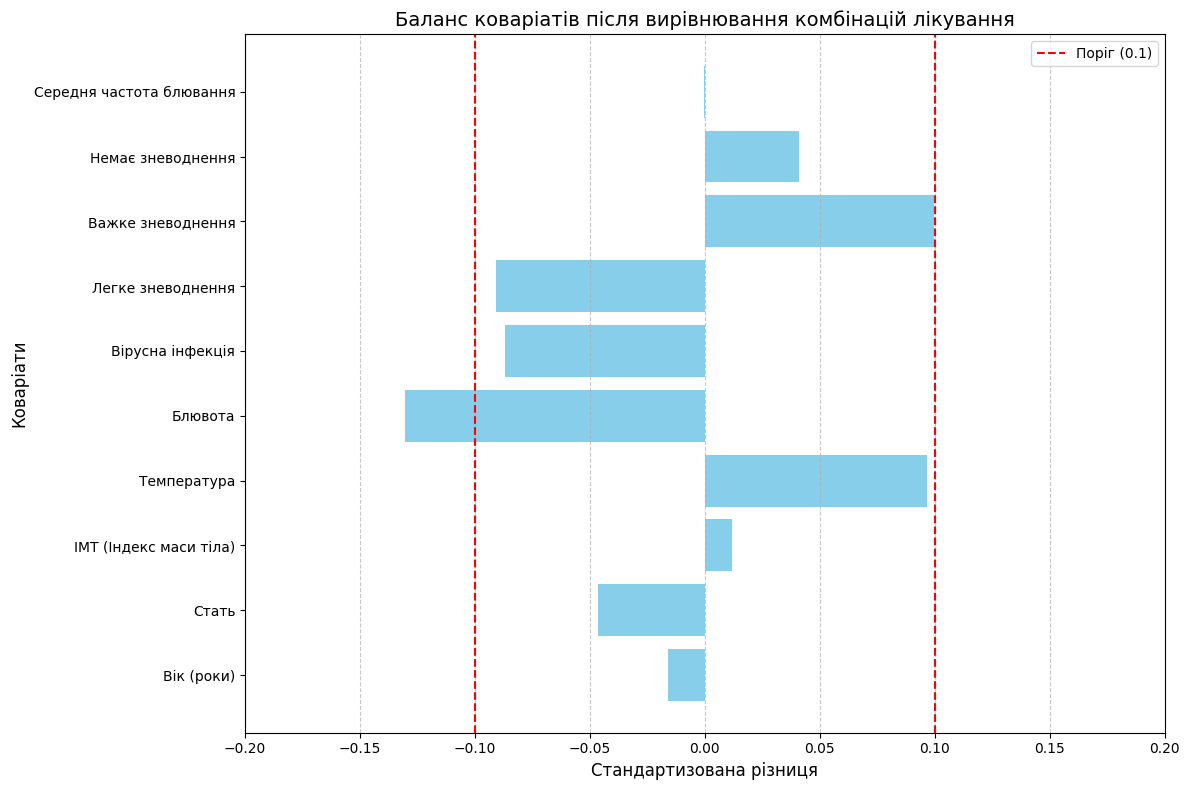

In [26]:
# Переклад назв коваріатів на українську мову
balanced_covariate_balance['Covariate Ukrainian'] = balanced_covariate_balance['Covariate'].map(covariate_mapping_ukrainian)

# Візуалізація балансу коваріатів
plt.figure(figsize=(12, 8))

# Горизонтальна гістограма для балансу коваріатів
plt.barh(
    balanced_covariate_balance['Covariate Ukrainian'],  # Використовуємо перекладені назви
    balanced_covariate_balance['Standardized Difference'], 
    color='skyblue'
)

# Додаткові лінії порогу
plt.axvline(x=0.1, color='r', linestyle='--', label='Поріг (0.1)')
plt.axvline(x=-0.1, color='r', linestyle='--')

# Обмеження для осі X
plt.xlim(-0.2, 0.2)

# Додавання назв і підписів
plt.title('Баланс коваріатів після вирівнювання комбінацій лікування', fontsize=14)
plt.xlabel('Стандартизована різниця', fontsize=12)
plt.ylabel('Коваріати', fontsize=12)

# Додавання сітки та легенди
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()


In [27]:
balanced_subjects.drop(columns=['vomitfl'], inplace=True)


In [28]:
balanced_subjects.columns

Index(['subjid', 'sex', 'temp', 'virusfl', 'hosp_days', 'age_years',
       'antibioticfl', 'analgesicfl', 'probioticfl', 'treatment_combination',
       'combination_description', 'dehsev_Mild_dehydration',
       'dehsev_No_dehydration', 'dehsev_Severe_dehydration', 'BMI',
       'vomit_avgfrq', 'binary_treatment', 'propensity_score',
       'treatment_status', 'controlfl'],
      dtype='object')

In [29]:
# Calculate the median hospital stay
median_hosp_days = balanced_subjects['hosp_days'].median()
print(f"Median Hospital Stay: {median_hosp_days} days")


Median Hospital Stay: 4.0 days


In [30]:
# Define the event status based on hospital stay
balanced_subjects['event_occurred'] = (balanced_subjects['hosp_days'] > median_hosp_days).astype(int)


In [31]:
# Use hospital stay as the survival time
balanced_subjects['survival_time'] = balanced_subjects['hosp_days']


In [32]:
balanced_subjects['survival_time']

0       3
1      12
2       3
3       5
4       5
       ..
515     4
516     6
517     8
518     4
519     6
Name: survival_time, Length: 520, dtype: int64

In [33]:
balanced_subjects['treatment_combination'].unique()

array([  0,   1,  10, 100])

In [34]:
balanced_subjects


,subjid,sex,temp,virusfl,hosp_days,age_years,antibioticfl,analgesicfl,probioticfl,treatment_combination,...,dehsev_No_dehydration,dehsev_Severe_dehydration,BMI,vomit_avgfrq,binary_treatment,propensity_score,treatment_status,controlfl,event_occurred,survival_time
0,480,2.0,38.4,0.0,3,1.597032,0,0,0,0,...,0.0,0.0,17.419074,9.500000,0,0.001174,Treated,0,0,3
1,764,1.0,36.8,1.0,12,0.433105,0,0,0,0,...,1.0,0.0,15.384615,4.296336,0,0.000549,Treated,0,1,12
2,289,2.0,37.3,1.0,3,0.788356,0,0,0,0,...,1.0,0.0,16.568047,4.500000,0,0.000630,Control,1,0,3
3,312,2.0,36.4,0.0,5,3.541096,0,0,0,0,...,0.0,0.0,16.966726,3.500000,0,0.000367,Treated,0,1,5
4,587,2.0,36.8,1.0,5,1.250000,0,0,0,0,...,0.0,0.0,16.326531,4.500000,0,0.001700,Control,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,602,1.0,36.1,0.0,4,1.000000,1,0,0,100,...,0.0,0.0,16.219723,4.296336,0,0.000389,Control,1,0,4
516,834,1.0,36.3,0.0,6,1.046575,1,0,0,100,...,1.0,0.0,16.326531,6.500000,0,0.000265,Control,1,1,6
517,325,1.0,38.0,0.0,8,0.718721,1,0,0,100,...,1.0,0.0,15.593673,2.500000,0,0.000820,Control,1,1,8
518,266,1.0,38.5,1.0,4,2.010959,1,0,0,100,...,0.0,1.0,13.887135,5.500000,0,0.002626,Control,1,0,4


In [35]:
balanced_subjects.columns

Index(['subjid', 'sex', 'temp', 'virusfl', 'hosp_days', 'age_years',
       'antibioticfl', 'analgesicfl', 'probioticfl', 'treatment_combination',
       'combination_description', 'dehsev_Mild_dehydration',
       'dehsev_No_dehydration', 'dehsev_Severe_dehydration', 'BMI',
       'vomit_avgfrq', 'binary_treatment', 'propensity_score',
       'treatment_status', 'controlfl', 'event_occurred', 'survival_time'],
      dtype='object')

In [36]:
balanced_subjects = balanced_subjects[balanced_subjects['antibioticfl'] == 0]

In [37]:
len(balanced_subjects)

390

In [38]:
# Step 2: Define covariates and necessary columns for Cox model
cox_covariates = [
 'sex', 'temp', 'virusfl',  'age_years',
 'dehsev_Mild_dehydration', 'dehsev_No_dehydration', 'dehsev_Severe_dehydration', 'BMI',
 'vomit_avgfrq',  'antibioticfl', 'analgesicfl', 'probioticfl', 'controlfl'
]

balanced_subjects

# Step 3: Ensure all covariates are numeric
bool_cols = balanced_subjects[cox_covariates].select_dtypes(include=['bool']).columns
balanced_subjects[bool_cols] = balanced_subjects[bool_cols].astype(int)

# Step 4: Include survival columns and stratification column
data_for_cox = balanced_subjects[
    cox_covariates + ['survival_time', 'event_occurred']
]

# Verify the structure of the new DataFrame
print("Columns in data_for_cox:\n", data_for_cox.columns)
print("First few rows:\n", data_for_cox.head())


Columns in data_for_cox:
 Index(['sex', 'temp', 'virusfl', 'age_years', 'dehsev_Mild_dehydration',
       'dehsev_No_dehydration', 'dehsev_Severe_dehydration', 'BMI',
       'vomit_avgfrq', 'antibioticfl', 'analgesicfl', 'probioticfl',
       'controlfl', 'survival_time', 'event_occurred'],
      dtype='object')
First few rows:
    sex  temp  virusfl  age_years  dehsev_Mild_dehydration  \
0  2.0  38.4      0.0   1.597032                      1.0   
1  1.0  36.8      1.0   0.433105                      0.0   
2  2.0  37.3      1.0   0.788356                      0.0   
3  2.0  36.4      0.0   3.541096                      1.0   
4  2.0  36.8      1.0   1.250000                      1.0   

   dehsev_No_dehydration  dehsev_Severe_dehydration        BMI  vomit_avgfrq  \
0                    0.0                        0.0  17.419074      9.500000   
1                    1.0                        0.0  15.384615      4.296336   
2                    1.0                        0.0  16.568047

In [39]:
data_for_cox.columns

Index(['sex', 'temp', 'virusfl', 'age_years', 'dehsev_Mild_dehydration',
       'dehsev_No_dehydration', 'dehsev_Severe_dehydration', 'BMI',
       'vomit_avgfrq', 'antibioticfl', 'analgesicfl', 'probioticfl',
       'controlfl', 'survival_time', 'event_occurred'],
      dtype='object')

In [40]:
from lifelines import CoxPHFitter

# Define covariates excluding treatment_combination_1
cox_covariates = [
  'temp',  'sex', 
'dehsev_Mild_dehydration', 'dehsev_Severe_dehydration', 
 'vomit_avgfrq',  'antibioticfl', 'analgesicfl', 'probioticfl', 'controlfl'
]

from lifelines import CoxPHFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Step 1: Check VIF
X = data_for_cox[cox_covariates]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)




                     feature        VIF
0                       temp  20.347216
1                        sex   9.190086
2    dehsev_Mild_dehydration   7.586458
3  dehsev_Severe_dehydration   1.337306
4               vomit_avgfrq   4.524180
5               antibioticfl        NaN
6                analgesicfl   2.242540
7                probioticfl   2.362046
8                  controlfl   2.855221


c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [41]:
# Step 4: Fit Cox model with penalization
cox_model = CoxPHFitter(penalizer=0.1)  # Add regularization
cox_model.fit(
    data_for_cox[cox_covariates + ['survival_time', 'event_occurred']],
    duration_col='survival_time',
    event_col='event_occurred',
    strata=['antibioticfl', 'dehsev_Mild_dehydration']
)

<lifelines.CoxPHFitter: fitted with 390 total observations, 290 right-censored observations>

In [42]:
cox_model.check_assumptions(data_for_cox[cox_covariates + ['survival_time', 'event_occurred']], show_plots=False, p_value_threshold=0.05)


Proportional hazard assumption looks okay.


[]

In [43]:
cox_summary = cox_model.summary

In [44]:
cox_summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
temp,-0.131451,0.876822,0.107751,-0.342638,0.079736,0.709895,1.083001,0.0,-1.219956,0.222482,2.168242
sex,0.166745,1.181453,0.178283,-0.182684,0.516174,0.833032,1.675604,0.0,0.935282,0.349643,1.516045
dehsev_Severe_dehydration,0.733685,2.082741,0.472160,-0.191733,1.659102,0.825527,5.254591,0.0,1.553888,0.120211,3.056358
vomit_avgfrq,-0.032670,0.967858,0.044060,-0.119027,0.053687,0.887784,1.055154,0.0,-0.741475,0.458405,1.125305
analgesicfl,0.318817,1.375499,0.211276,-0.095276,0.732909,0.909122,2.081127,0.0,1.509008,0.131297,2.929098
probioticfl,-0.406492,0.665982,0.223411,-0.844369,0.031385,0.429828,1.031883,0.0,-1.819482,0.068838,3.860652
controlfl,0.257080,1.293149,0.184224,-0.103992,0.618152,0.901233,1.855495,0.0,1.395478,0.162872,2.618192


In [45]:
# Define the FL variables
fl_variables = ['analgesicfl', 'probioticfl', 'controlfl']

# Extract treatment effects for FL variables
treatment_effects = cox_summary.loc[
    fl_variables,
    ['coef', 'exp(coef)', 'p']
]

# Rename columns for better readability
treatment_effects = treatment_effects.rename(columns={'exp(coef)': 'Hazard Ratio'})

# Print treatment effects
print("\nTreatment Effects (Hazard Ratios):")
print(treatment_effects)



Treatment Effects (Hazard Ratios):
                 coef  Hazard Ratio         p
covariate                                    
analgesicfl  0.318817      1.375499  0.131297
probioticfl -0.406492      0.665982  0.068838
controlfl    0.257080      1.293149  0.162872


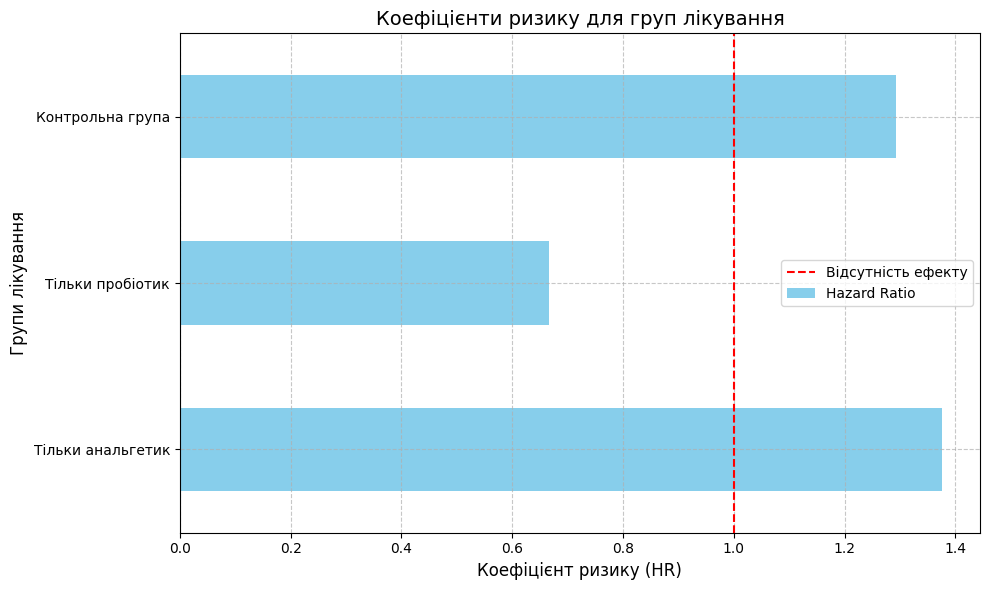

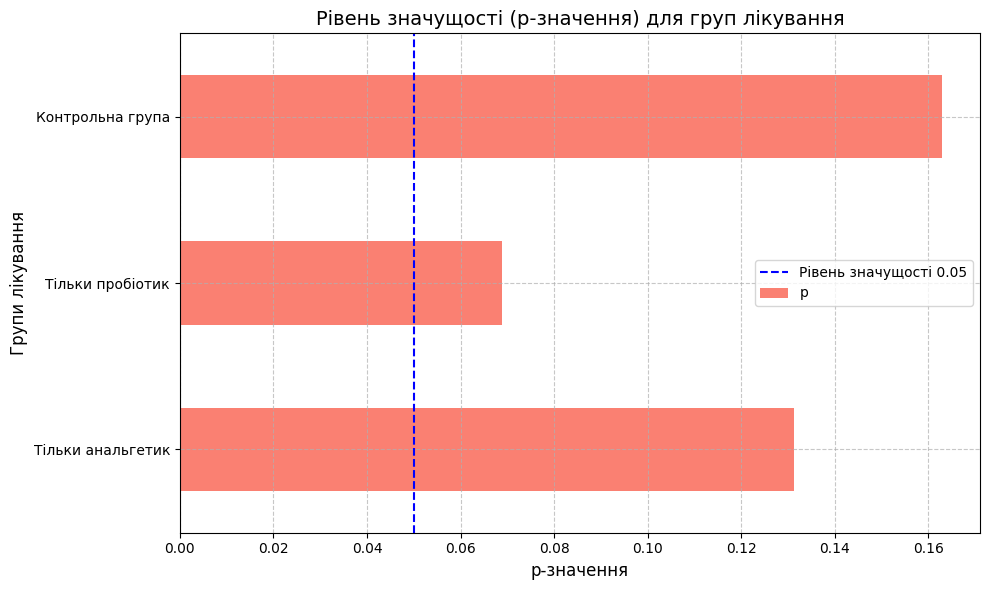

In [46]:
import matplotlib.pyplot as plt

# Define the mapping for Ukrainian treatment names
treatment_mapping_ukrainian = {
    "antibioticfl": "Тільки антибіотик",
    "analgesicfl": "Тільки анальгетик",
    "probioticfl": "Тільки пробіотик",
    "controlfl": "Контрольна група"
}

# Ensure 'Hazard Ratio' is available
cox_summary = cox_summary.rename(columns={'exp(coef)': 'Hazard Ratio'})

# Filter treatment coefficients (FL variables)
available_treatment_covariates = ['antibioticfl', 'analgesicfl', 'probioticfl', 'controlfl']
available_treatment_covariates = [var for var in available_treatment_covariates if var in cox_summary.index]

# Check if there are any available covariates
if not available_treatment_covariates:
    raise ValueError("No treatment covariates found in the Cox model summary.")

# Filter the summary for the available covariates
treatment_effects = cox_summary.loc[available_treatment_covariates, ['coef', 'Hazard Ratio', 'p']]

# Translate the treatment labels into Ukrainian
treatment_effects['Ukrainian Label'] = [
    treatment_mapping_ukrainian.get(col, col) for col in available_treatment_covariates
]

# Plot Hazard Ratios with Ukrainian Labels
fig, ax = plt.subplots(figsize=(10, 6))
treatment_effects.set_index('Ukrainian Label')['Hazard Ratio'].plot(kind='barh', ax=ax, legend=False, color='skyblue')
plt.title('Коефіцієнти ризику для груп лікування', fontsize=14)
plt.xlabel('Коефіцієнт ризику (HR)', fontsize=12)
plt.ylabel('Групи лікування', fontsize=12)
plt.axvline(x=1, color='red', linestyle='--', label='Відсутність ефекту')
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot p-values with Ukrainian Labels
fig, ax = plt.subplots(figsize=(10, 6))
treatment_effects.set_index('Ukrainian Label')['p'].plot(kind='barh', ax=ax, legend=False, color='salmon')
plt.title('Рівень значущості (p-значення) для груп лікування', fontsize=14)
plt.xlabel('p-значення', fontsize=12)
plt.ylabel('Групи лікування', fontsize=12)
plt.axvline(x=0.05, color='blue', linestyle='--', label='Рівень значущості 0.05')
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
